In [122]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun, dist
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [28]:
# wavelet params
waves = ["db5", "sym5", "coif2"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [29]:
dics = []
for i in range(len(dirs)):
    # define indexes
    res = results[i]
    mos = models[i]
    lamL1wave = np.array(res['lamL1wave'])
    lamL1attr = np.array(res['lamL1attr'])
    lamL1wave_grid = np.unique(lamL1wave)
    lamL1attr_grid = np.unique(lamL1attr)
    R = len(lamL1wave_grid)
    C = len(lamL1attr_grid)

    # original wavelet
    wt_o = DWT1d(wave='db5', mode=mode, J=J).to(device)
    phi_o, psi_o, x_o = get_wavefun(wt_o)

    # collect results
    dic = {'psi':{},
           'wt': {},
           'dist': {},
           'lamL1wave': {},
           'lamL1attr': {},
           'index': {}}

    for r in range(R):
        for c in range(C):
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)
                d = dist(wt, wt_o)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi
                dic['dist'][(r,c)] = d        
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]
    dics.append(dic)

# wavelet with min L1 distance

In [71]:
wlist = []
for i in range(len(dirs)):
    # collect results
    dic = {'bestAWD': {},
           'init': {},
           'h': {},
           'x': {},
           'curve': {},
           'lam': {},
           'gam': {}}
    
    min_dist = min(dics[i]['dist'].values())
    r, c = [key for key in dics[i]['dist'] if dics[i]['dist'][key] == min_dist][0]
    wt = dics[i]['wt'][(r,c)]
    phi, psi, x = get_wavefun(wt)
    
    # initialization
    if waves[i] == 'db5':
        torch.manual_seed(p.seed) 
        wt_i = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.3).to(device)
    else:
        wt_i = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)        
    phi_i, psi_i, x_i = get_wavefun(wt_i)  
    
    
    dic['bestAWD'] = psi
    dic['init'] = psi_i
    dic['x'] = x
    dic['h'] = wt_i.h0.detach().squeeze().cpu().numpy()
    
    lam = dics[i]['lamL1wave'][(r,c)]
    gam = [dics[i]['lamL1attr'][(r,c)] for c in range(C)]
    curve = [dics[i]['dist'][(r,c)] for c in range(C)]
    dic['lam'] = lam
    dic['gam'] = gam
    dic['curve'] = curve
    
    wlist.append(dic)

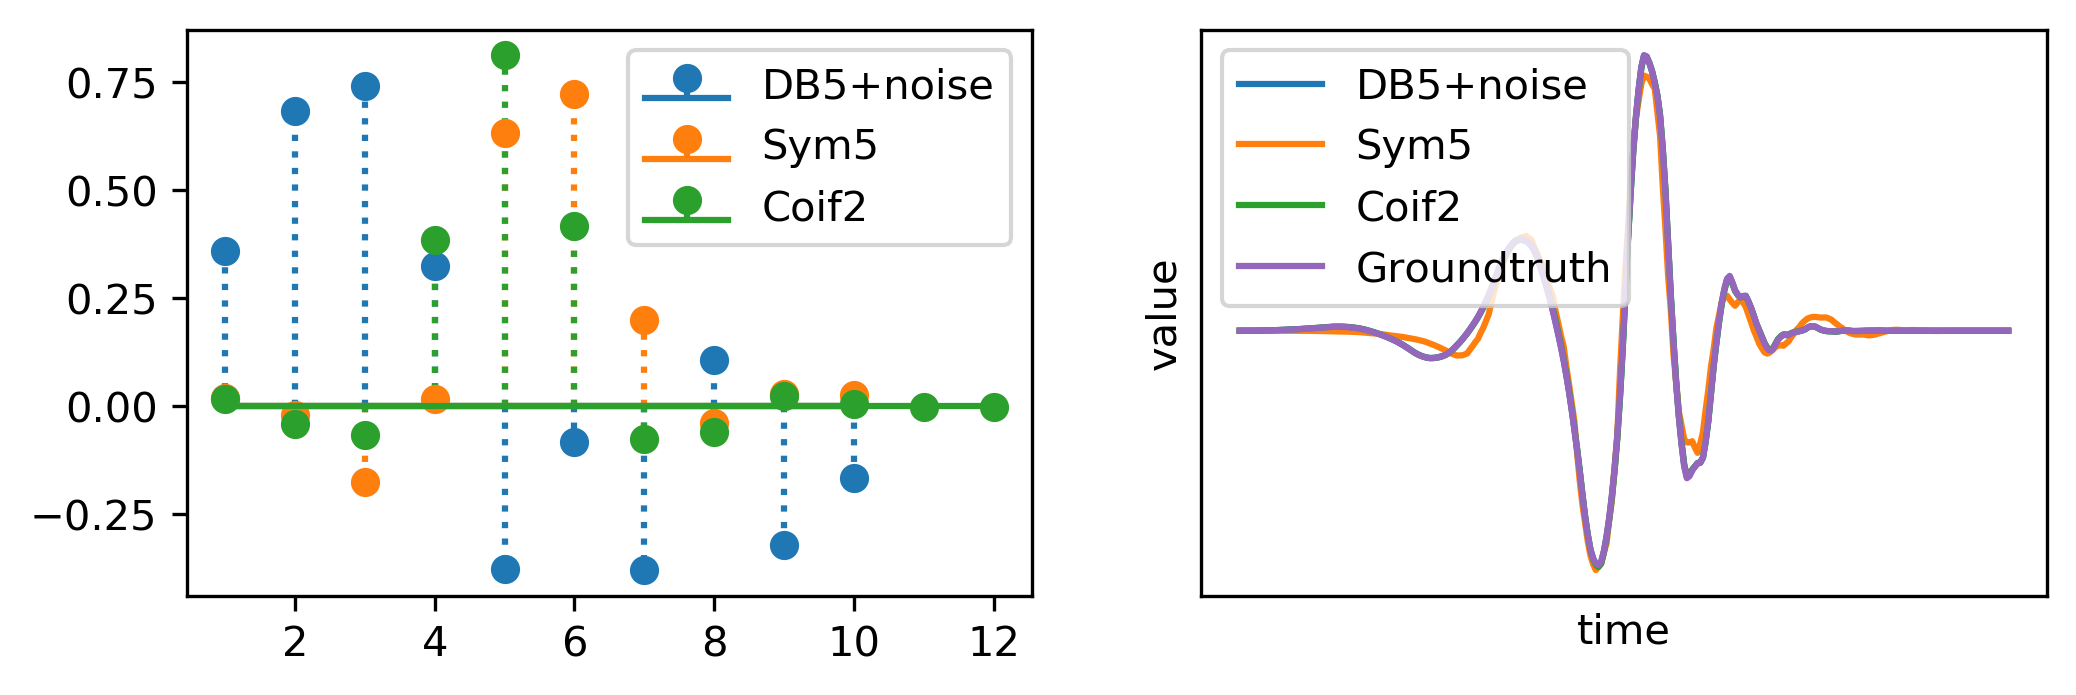

In [127]:
fig = plt.figure(dpi=300, figsize=(8,2.5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
labels = ['DB5+noise', 'Sym5', 'Coif2']

ax_00 = fig.add_subplot(spec[0, 0])
h_i_db5 = np.pad(wlist[0]['h'], (1,1), mode='constant', constant_values=(0,0))
h_i_sym5 = np.pad(wlist[1]['h'], (1,1), mode='constant', constant_values=(0,0))
h_i_db5 = wlist[0]['h']
h_i_sym5 = wlist[1]['h']
h_i_coif2 = wlist[2]['h']
ax_00.stem(np.arange(1,11), h_i_db5, label='DB5+noise', linefmt='C0:', basefmt='C0-', markerfmt='C0o', use_line_collection=True)
ax_00.stem(np.arange(1,11), h_i_sym5, label='Sym5', linefmt='C1:', basefmt='C1-', markerfmt='C1o', use_line_collection=True)
ax_00.stem(np.arange(1,13), h_i_coif2, label='Coif2', linefmt='C2:', basefmt='C2-', markerfmt='C2o', use_line_collection=True)
ax_00.legend(loc='upper right')
ax_00.xaxis.set_major_locator(MaxNLocator(integer=True))

ax_01 = fig.add_subplot(spec[0, 1])
x = wlist[1]['x']
psi_db5 = wlist[0]['bestAWD']
psi_sym5 = wlist[1]['bestAWD']
psi_coif2 = wlist[2]['bestAWD'][32:-32]
ax_01.plot(x/np.max(x), psi_db5, label='DB5+noise', linewidth=1.5, alpha=1.0, color='C0')
ax_01.plot(x/np.max(x), np.roll(psi_sym5[::-1],-5), label='Sym5', linewidth=1.5, alpha=1.0, color='C1')
ax_01.plot(x/np.max(x), np.roll(psi_coif2,2), label='Coif2', linewidth=1.5, alpha=1.0, color='C2')
ax_01.plot(x/np.max(x), psi_o, label='Groundtruth', linewidth=1.5, alpha=1.0, color='C4')
ax_01.get_xaxis().set_ticks([])
ax_01.get_yaxis().set_ticks([])
ax_01.set_xlabel('time')
ax_01.set_ylabel('value')  
ax_01.legend(loc='upper left')
plt.savefig('figures/sim_main.pdf', bbox_inches='tight')

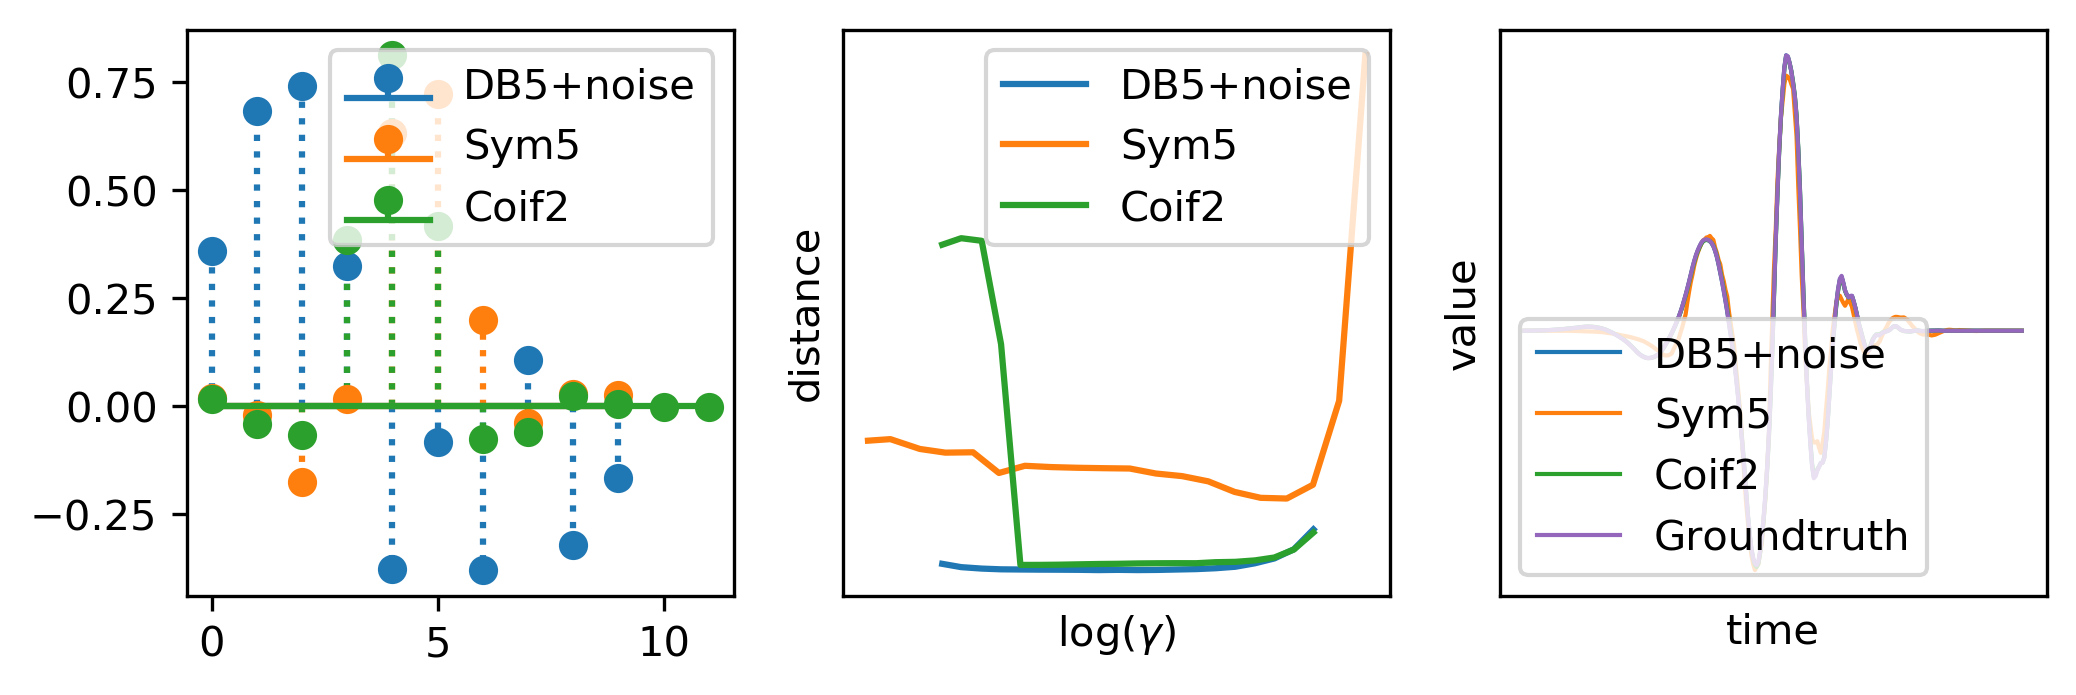

In [108]:
# fig = plt.figure(dpi=300, figsize=(8,2.5))
# spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
# labels = ['DB5+noise', 'Sym5', 'Coif2']

# ax_00 = fig.add_subplot(spec[0, 0])
# h_i_db5 = np.pad(wlist[0]['h'], (1,1), mode='constant', constant_values=(0,0))
# h_i_sym5 = np.pad(wlist[1]['h'], (1,1), mode='constant', constant_values=(0,0))
# h_i_db5 = wlist[0]['h']
# h_i_sym5 = wlist[1]['h']
# h_i_coif2 = wlist[2]['h']
# ax_00.stem(np.arange(10), h_i_db5, label='DB5+noise', linefmt='C0:', basefmt='C0-', markerfmt='C0o', use_line_collection=True)
# ax_00.stem(np.arange(10), h_i_sym5, label='Sym5', linefmt='C1:', basefmt='C1-', markerfmt='C1o', use_line_collection=True)
# ax_00.stem(np.arange(12), h_i_coif2, label='Coif2', linefmt='C2:', basefmt='C2-', markerfmt='C2o', use_line_collection=True)
# # ax_00.plot(np.arange(12), h_i_db5, label='DB5+noise', linewidth=1, alpha=1.0, color='C0')
# # ax_00.plot(np.arange(12), h_i_sym5, label='Sym5', linewidth=1, alpha=1.0, color='C1')
# # ax_00.plot(np.arange(12), h_i_coif2, label='Coif2', linewidth=1, alpha=1.0, color='C2')
# # ax_00.get_xaxis().set_ticks([])
# # ax_00.get_yaxis().set_ticks([])
# ax_00.legend(loc='upper right')

# # x = wlist[1]['x']
# # psi_i_db5 = wlist[0]['init']
# # psi_i_sym5 = wlist[1]['init']
# # psi_i_coif2 = wlist[2]['init'][32:-32]
# # ax_00.plot(x/np.max(x), psi_i_db5, label='DB5+noise', linewidth=1, alpha=1.0, color='C0')
# # ax_00.plot(x/np.max(x), psi_i_sym5, label='Sym5', linewidth=1, alpha=1.0, color='C1')
# # ax_00.plot(x/np.max(x), psi_i_coif2, label='Coif2', linewidth=1, alpha=1.0, color='C2')
# # ax_00.get_xaxis().set_ticks([])
# # ax_00.get_yaxis().set_ticks([])
# # vmin = min(psi_i_coif2)*1.2
# # vmax = max(psi_i_coif2)*1.2
# # ax_00.set_ylim([vmin, vmax])
# # ax_00.set_xlabel('time')
# # ax_00.set_ylabel('value')  
# # ax_00.legend(loc='lower left')

# ax_01 = fig.add_subplot(spec[0, 1])
# for i in range(len(dirs)):
#     lam = wlist[i]['lam']
#     gam = wlist[i]['gam'][1:]
#     curve = wlist[i]['curve'][1:]
#     ax_01.plot(np.log(gam), curve, label='{}'.format(labels[i]))
# ax_01.get_xaxis().set_ticks([])
# ax_01.get_yaxis().set_ticks([])    
# ax_01.set_xlabel('$\log(\gamma)$')
# ax_01.set_ylabel('distance')
# ax_01.legend(loc='upper right')  

# ax_02 = fig.add_subplot(spec[0, 2])
# x = wlist[1]['x']
# psi_db5 = wlist[0]['bestAWD']
# psi_sym5 = wlist[1]['bestAWD']
# psi_coif2 = wlist[2]['bestAWD'][32:-32]
# ax_02.plot(x/np.max(x), psi_db5, label='DB5+noise', linewidth=1, alpha=1.0, color='C0')
# ax_02.plot(x/np.max(x), np.roll(psi_sym5[::-1],-5), label='Sym5', linewidth=1, alpha=1.0, color='C1')
# ax_02.plot(x/np.max(x), np.roll(psi_coif2,2), label='Coif2', linewidth=1, alpha=1.0, color='C2')
# ax_02.plot(x/np.max(x), psi_o, label='Groundtruth', linewidth=1, alpha=1.0, color='C4')
# ax_02.get_xaxis().set_ticks([])
# ax_02.get_yaxis().set_ticks([])
# ax_02.set_xlabel('time')
# ax_02.set_ylabel('value')  
# ax_02.legend(loc='lower left')

In [111]:
# # distance plot
# fig = plt.figure(dpi=300)
# spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

# ax = fig.add_subplot(spec[0, 0])
# for i in range(len(dirs)):
#     lam = wlist[i]['lam']
#     gam = wlist[i]['gam'][1:]
#     curve = wlist[i]['curve'][1:]
#     ax.plot(np.log(gam), curve, label='{}'.format(waves[i]))
# ax.set_xlabel('$\log(\gamma)$')
# ax.set_ylabel('distance')
# ax.legend(loc='upper right')   


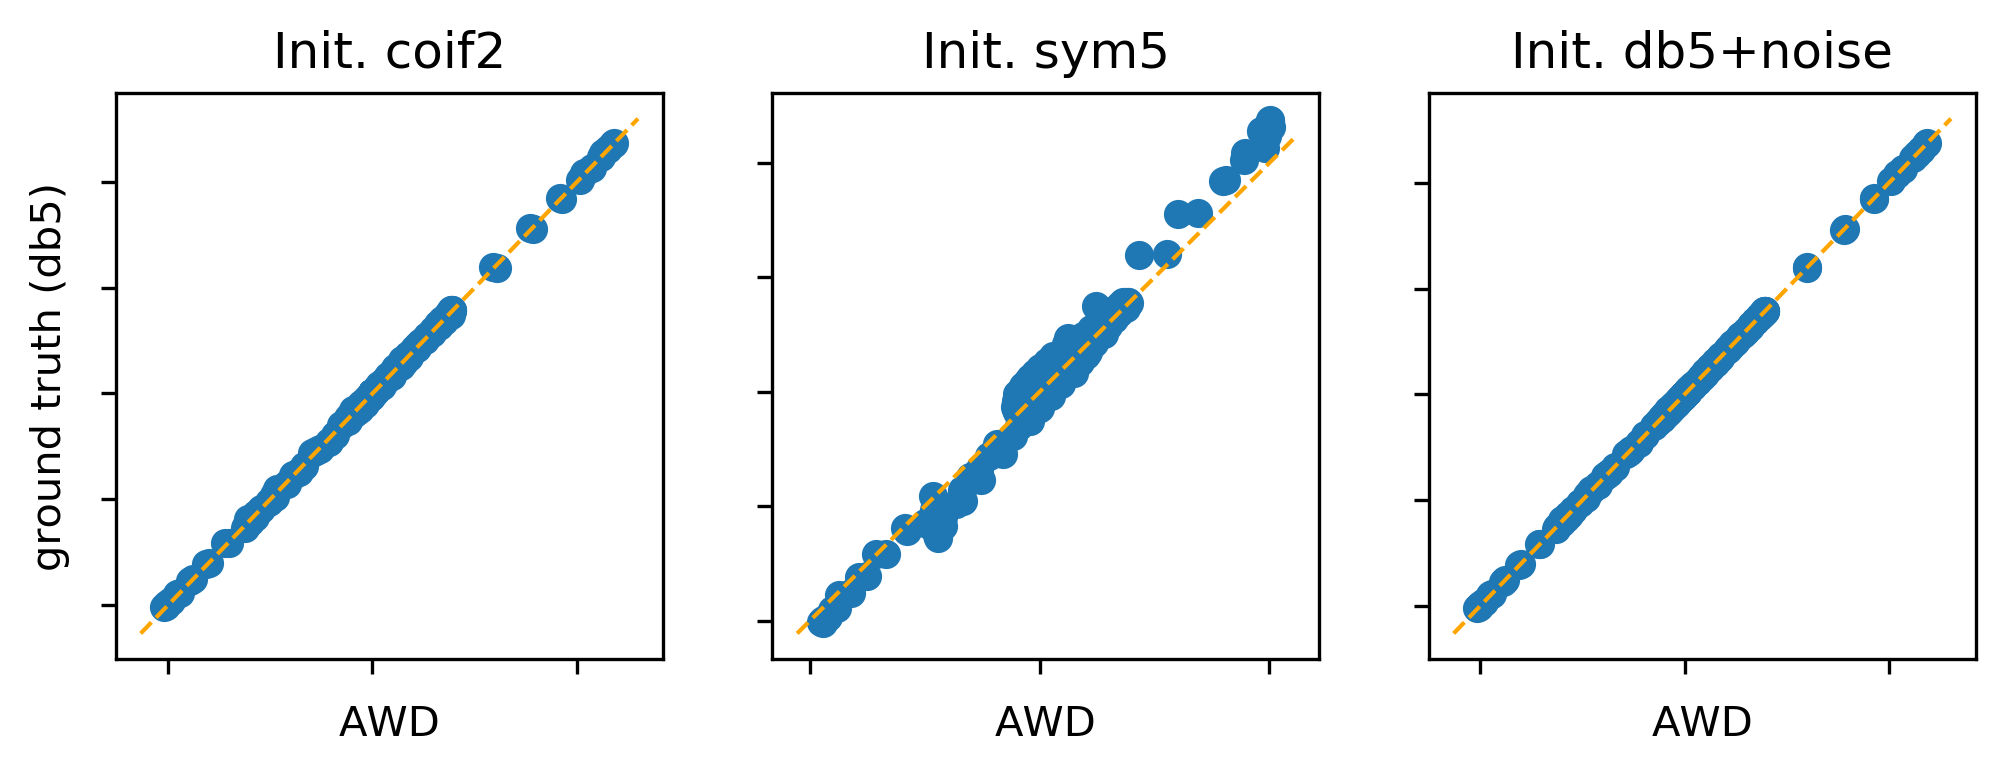

In [66]:
fig = plt.figure(dpi=300, figsize=(8,2.5))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

ax_00 = fig.add_subplot(spec[0, 2])
idx = 0
psi = wlist[idx]['bestAWD']
x = wlist[idx]['x']
ax_00.scatter(psi, psi_o)
ax_00.set_xlabel('AWD') 
ax_00.set_title('Init. db5+noise')
ax_00.set_xticklabels([])
ax_00.set_yticklabels([])
xpoints = ypoints = ax_00.get_xlim()
ax_00.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)

ax_01 = fig.add_subplot(spec[0, 1])
idx = 1
psi = wlist[idx]['bestAWD']
x = wlist[idx]['x']
ax_01.scatter(psi, np.roll(psi_o[::-1], -5))
ax_01.set_xlabel('AWD')
ax_01.set_title('Init. sym5')
ax_01.set_xticklabels([])
ax_01.set_yticklabels([])
xpoints = ypoints = ax_01.get_xlim()
ax_01.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)

ax_02 = fig.add_subplot(spec[0, 0])
idx = 2
psi = wlist[idx]['bestAWD']
x = wlist[idx]['x']
ax_02.scatter(psi[:288], np.roll(psi_o,30))
ax_02.set_xlabel('AWD')
ax_02.set_ylabel('ground truth (db5)')  
ax_02.set_title('Init. coif2')
ax_02.set_xticklabels([])
ax_02.set_yticklabels([])
xpoints = ypoints = ax_02.get_xlim()
ax_02.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)